# Extra - Exploring a Dataset

This notebook helps you explore some of the statistics/properties of a simulation dataset, showcases some of the data augmentations, and motivates the usage of crossings *vs.* collisional dynamics.

In [1]:
import os
import sys
import glob
import numpy as np

# uncomment the line below for nicer plots (needs LaTeX)
# os.environ['MATPLOTLIBRC'] = '../matplotlibrc'
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter

sys.path.append('../..')
from sheet_model.utils import get_dx_eq, get_E

## Load Data

In [2]:
X = np.array([np.load(v) for v in sorted(glob.glob('../../data/dataset/train/10/periodic/x_[0-9]*.npy'))])
X_eq = np.array([np.load(v) for v in sorted(glob.glob('../../data/dataset/train/10/periodic/x_eq*.npy'))])
V = np.array([np.load(v) for v in sorted(glob.glob('../../data/dataset/train/10/periodic/v_[0-9]*.npy'))])
dX = X - X_eq

dx_eq = get_dx_eq(X.shape[-1])
dX = dX/dx_eq
V = V/dx_eq

In [3]:
xrange = [-np.max(np.abs(dX)), np.max(np.abs(dX))]
vrange = [-np.max(np.abs(V)), np.max(np.abs(V))]

### Sheet Velocities $v$ 

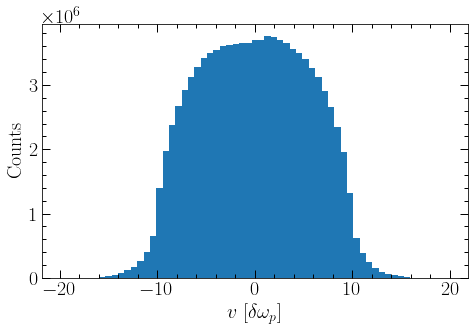

v_max: 19.9 [dx_eq w_p^-1]
v_min: -18.3 [dx_eq w_p^-1]
v_std: 5.6 [dx_eq]
percentiles: [ 2.20835368  4.46852666  6.94217502  9.67486103 11.83358359]


In [4]:
plt.figure()
plt.hist(V.flatten(), bins=61, range=vrange)
plt.xlabel('$v$ [$\delta\omega_p$]')
plt.ylabel('Counts')
plt.tight_layout()
plt.savefig('../img/train_data_vdist.pdf')
plt.show()
print(f'v_max: {np.max(V):.1f} [dx_eq w_p^-1]')
print(f'v_min: {np.min(V):.1f} [dx_eq w_p^-1]')
print(f'v_std: {np.std(V):.1f} [dx_eq]')
print(f'percentiles: {np.percentile(np.abs(V),[25,50,75,95,99])}')

### Displacements from equilibrium position $\xi = (x - x_{eq})$

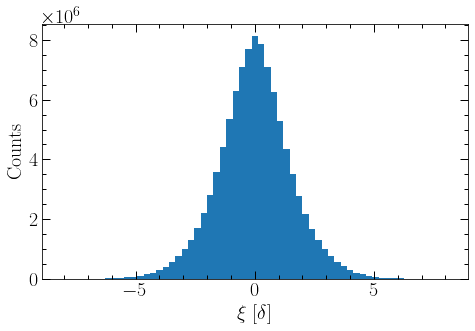

dx_max: 8.0 [dx_eq]
dx_min: -8.1 [dx_eq]
dx_std: 1.5 [dx_eq]
percentiles: [0.42414054 0.92510052 1.65776768 3.10383677 4.25969189]


In [5]:
plt.figure()
plt.hist(dX.flatten(), bins=61,range=xrange)
plt.xlabel(r'$\xi$ [$\delta$]')
plt.ylabel('Counts')
plt.tight_layout()
plt.savefig('../img/train_data_xdist.pdf')
plt.show()
print(f'dx_max: {np.max(dX):.1f} [dx_eq]')
print(f'dx_min: {np.min(dX):.1f} [dx_eq]')
print(f'dx_std: {np.std(dX):.1f} [dx_eq]')
print(f'percentiles: {np.percentile(np.abs(dX),[25,50,75,95,99])}')

### Joint distribution

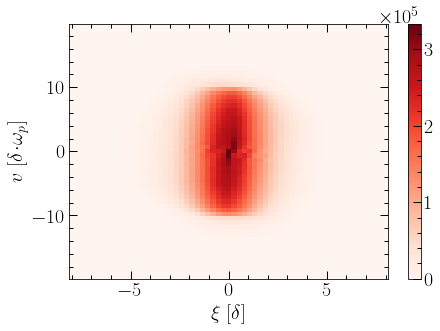

In [6]:
plt.figure()
im = plt.hist2d(dX.flatten(), V.flatten(), bins=61, range=[xrange, vrange], cmap='Reds')
plt.xlabel(r'$\xi$ [$\delta$]')
plt.ylabel('$v$ [$\delta\!\cdot\!\omega_p$]')
cbar = plt.colorbar()
cbar.formatter.set_powerlimits((0, 0))
cbar.update_ticks()
plt.tight_layout()
plt.show()

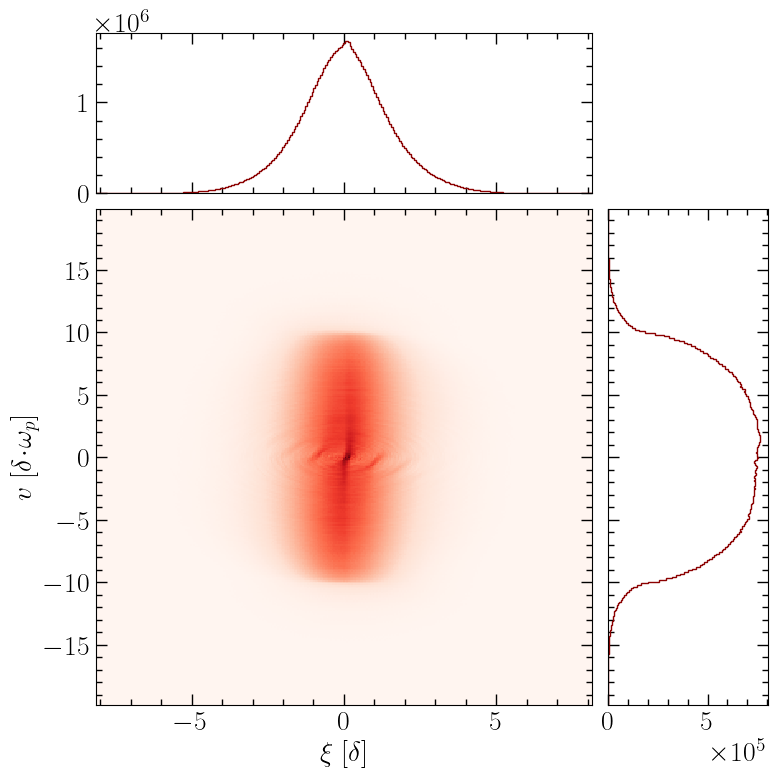

In [7]:
# no labels
nullfmt = NullFormatter()         

# definitions for the axes
left, width = 0.12, 0.62
bottom, height = 0.1, 0.62
bottom_h = left_h = left + width + 0.02

rect_histxy = [left, bottom, width, height]
rect_histx = [left, bottom_h - 0.02, width, 0.2]
rect_histy = [left_h, bottom, 0.2, height]

# start with a rectangular Figure
plt.figure(1, figsize=(8, 8))

axHistxy = plt.axes(rect_histxy)
axHistx = plt.axes(rect_histx)
axHisty = plt.axes(rect_histy)

# no labels
axHistx.xaxis.set_major_formatter(nullfmt)
axHisty.yaxis.set_major_formatter(nullfmt)

# 2D hist
bins=301
axHistxy.hist2d(dX.flatten(), V.flatten(), bins=bins, range=[xrange, vrange], cmap='Reds', rasterized=True)
axHistxy.set_xlabel(r'$\xi$ [$\delta$]')
axHistxy.set_ylabel('$v$ [$\delta\!\cdot\!\omega_p$]')


# 1D hist
axHistx.hist(dX.flatten(), bins=bins, range=xrange, color='darkred', histtype='step')
axHisty.hist(V.flatten(), bins=bins, range=vrange, orientation='horizontal', color='darkred', histtype='step')
axHistx.set_xlim(axHistxy.get_xlim())
axHisty.set_ylim(axHistxy.get_ylim())
axHistx.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
axHisty.ticklabel_format(axis='x', style='sci', scilimits=(0,0))

plt.savefig('../img/train_data_dist')
plt.show()

## Energy Conservation

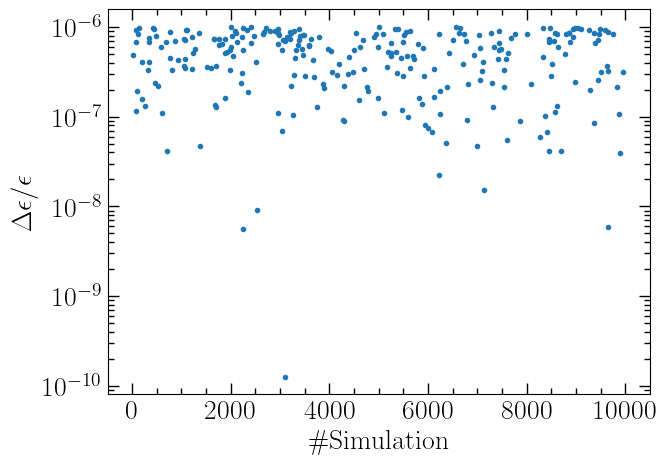

In [8]:
E = np.array([get_E(x, v*dx_eq, x_eq) for x, v, x_eq in zip(X, V, X_eq)])
E = np.sum(E, axis=1)

plt.figure()
plt.plot((E[:,0] - E[:,-1])/E[:,0], '.')
plt.ylabel('$\Delta \epsilon / \epsilon$')
plt.xlabel('\#Simulation')
plt.yscale('log')
plt.show()

## Rank of Crossings

max != 0 [7]
max != 0 [4]


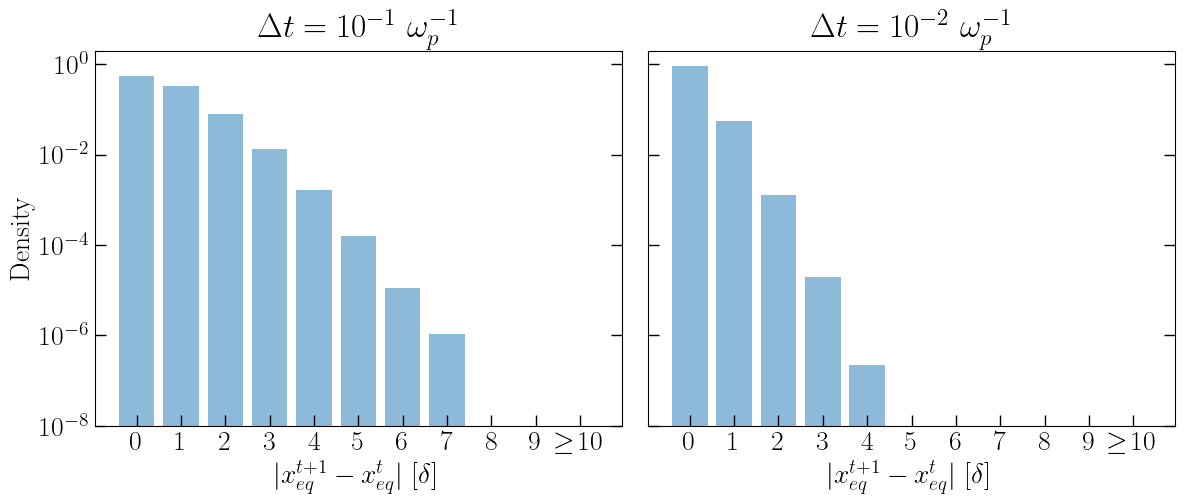

In [9]:
# using test set with reflecting boundaries
X_eq = np.array([np.load(v) for v in sorted(glob.glob('../../data/dataset/test/1000/reflecting/x_eq*.npy'))])
dx_eq = get_dx_eq(X_eq.shape[-1])

fig, ax = plt.subplots(1,2, figsize=(12,5), sharex=True, sharey=True,
                      gridspec_kw={'wspace': 0.05, 'bottom': 0.15, 'top': 0.90, 'left': 0.09, 'right': 0.99})

for i, undersample in enumerate([10,1]):
    
    aux = X_eq[:,::undersample]
    rank_change = np.diff(aux, axis=1) / dx_eq
    rank_change = rank_change.flatten()
    h, bins = np.histogram(np.abs(rank_change), bins=list(np.linspace(-0.5, 9.5, 11)) + [np.inf])
    ax[i].bar(range(len(h)), h / np.sum(h), alpha=0.5)
    print('max != 0', np.argwhere(h[h!=0])[-1])

for a in ax:
    a.set_xticks(range(len(h)), minor=False)
    a.set_xticklabels(list(range(10)) + ['$\geq\!10$'])
    a.tick_params(axis='x', which='minor', bottom=False, top=False)
    a.tick_params(axis='x', which='major', top=False)


plt.setp(ax, yscale='log')
plt.setp(ax, ylim=(np.min(h[h!=0])/np.sum(h), 2))
ax[0].set_ylabel('Density')
ax[0].set_yticks(10.**np.arange(-8,2,2))
plt.setp(ax, xlabel='$|x^{t+1}_{eq}-x^{t}_{eq}|$ $[\delta]$')

ax[0].set_title('$\Delta t = 10^{-1} \ \omega_p^{-1}$', pad=10)
ax[1].set_title('$\Delta t = 10^{-2} \ \omega_p^{-1}$', pad=10)

plt.savefig('../img/dataset_rankchange_test.pdf')
plt.show()

max != 0 [10]
max != 0 [8]


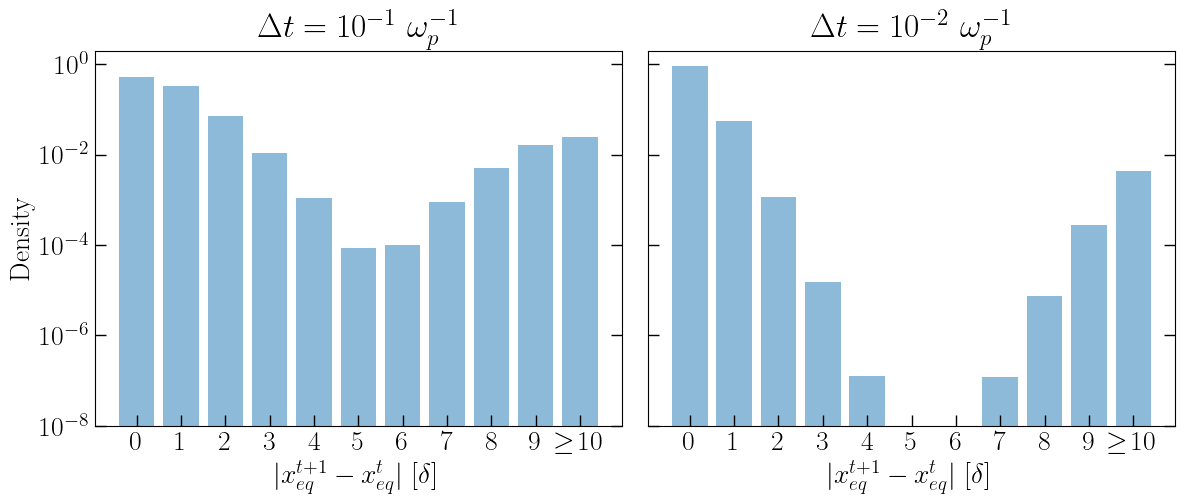

In [10]:
# using training set with periodic boundaries
X_eq = np.array([np.load(v) for v in sorted(glob.glob('../../data/dataset/train/10/periodic/x_eq*.npy'))])

dx_eq = get_dx_eq(X_eq.shape[-1])

fig, ax = plt.subplots(1,2, figsize=(12,5), sharex=True, sharey=True,
                      gridspec_kw={'wspace': 0.05, 'bottom': 0.15, 'top': 0.90, 'left': 0.09, 'right': 0.99})

for i, undersample in enumerate([10,1]):
    
    aux = X_eq[:,::undersample]
    rank_change = np.diff(aux, axis=1) / dx_eq
    rank_change = rank_change.flatten()
    h, bins = np.histogram(np.abs(rank_change), bins=list(np.linspace(-0.5, 9.5, 11)) + [np.inf])
    ax[i].bar(range(len(h)), h / np.sum(h), alpha=0.5)
    print('max != 0', np.argwhere(h[h!=0])[-1])

for a in ax:
    a.set_xticks(range(len(h)), minor=False)
    a.set_xticklabels(list(range(10)) + ['$\geq\!10$'])
    a.tick_params(axis='x', which='minor', bottom=False, top=False)
    a.tick_params(axis='x', which='major', top=False)


plt.setp(ax, yscale='log')
plt.setp(ax, ylim=(np.min(h[h!=0])/np.sum(h), 2))
ax[0].set_ylabel('Density')
ax[0].set_yticks(10.**np.arange(-8,2,2))
plt.setp(ax, xlabel='$|x^{t+1}_{eq}-x^{t}_{eq}|$ $[\delta]$')

ax[0].set_title('$\Delta t = 10^{-1} \ \omega_p^{-1}$', pad=10)
ax[1].set_title('$\Delta t = 10^{-2} \ \omega_p^{-1}$', pad=10)

plt.savefig('../img/dataset_rankchange_train.pdf')
plt.show()

## Data Augmentation

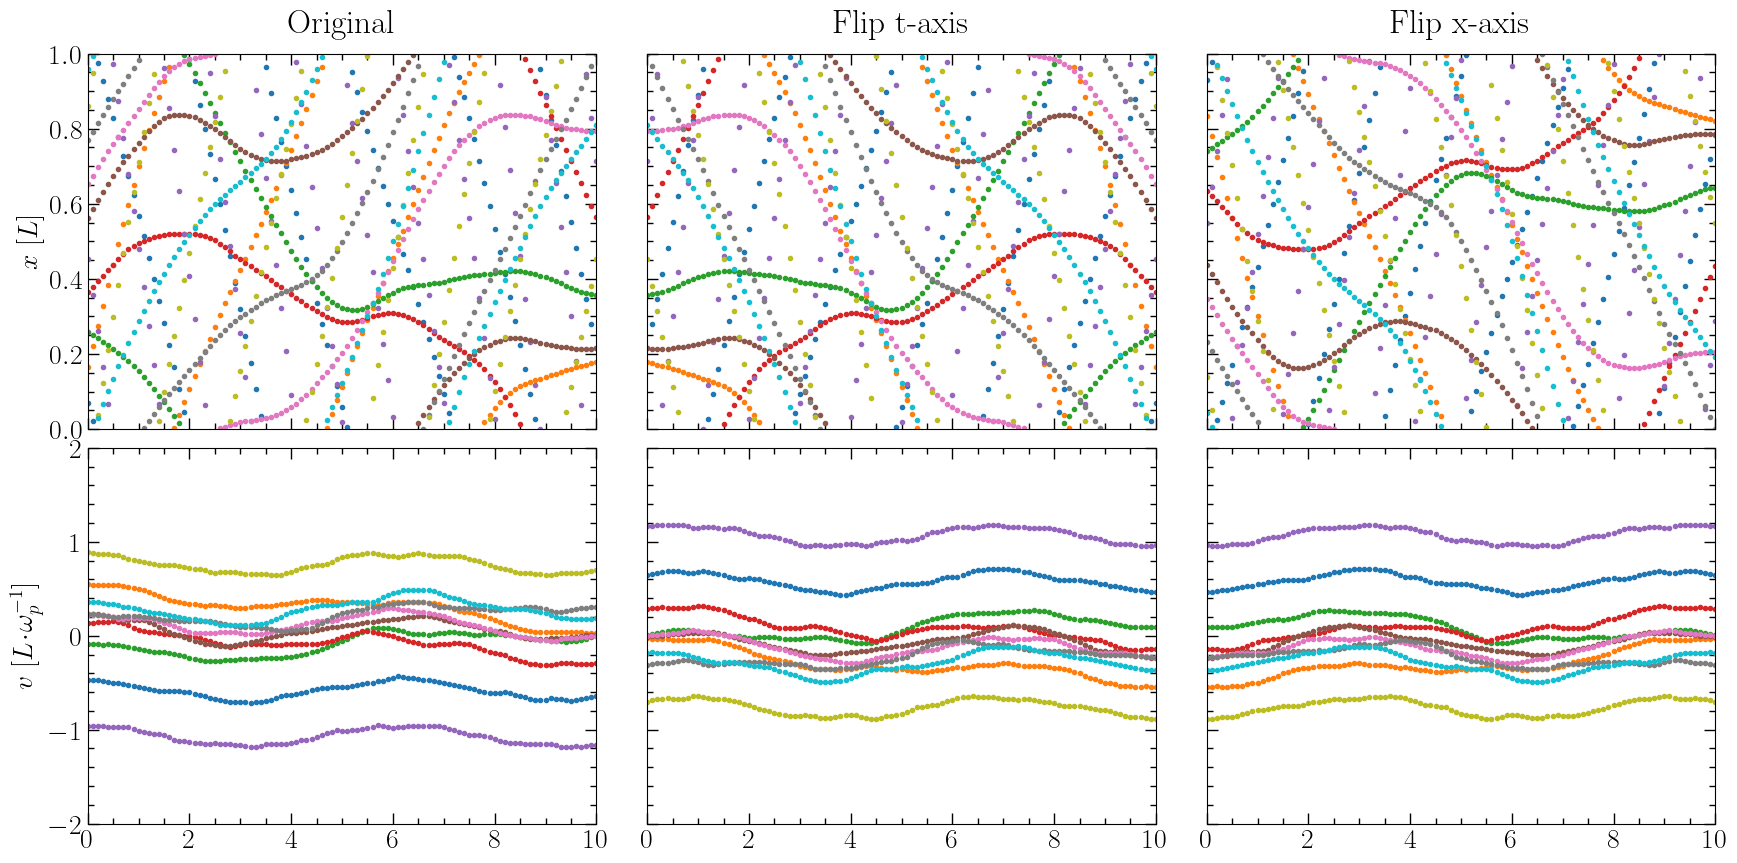

In [11]:
x = np.load('../../data/dataset/train/10/periodic/x_0001.npy')
v = np.load('../../data/dataset/train/10/periodic/v_0001.npy')
t = np.arange(0, 10.01, 0.01)

x = x[::10]
v = v[::10]
t = t[::10]

fig, ax = plt.subplots(2,3, figsize=(7*3,5*2), sharex=True, gridspec_kw={'wspace':0.1, 'hspace':0.05})

ax[0,0].plot(t, x, '.')
ax[0,1].plot(t, np.flip(x, axis=0), '.')
ax[0,2].plot(t, 1 - x, '.')

ax[1,0].plot(t, v, '.')
ax[1,1].plot(t, np.flip(-v, axis=0), '.')
ax[1,2].plot(t, -v, '.')

for a in ax[0]:
    a.set_ylim(0,1)

for a in ax[1]:
    a.set_ylim(-2,2)
    
for a in ax[:, 1:].flatten():
    a.set_yticklabels([])

plt.xlim(0, 10)

ax[0,0].set_title('Original', pad=15)
ax[0,1].set_title('Flip t-axis', pad=15)
ax[0,2].set_title('Flip x-axis', pad=15)

ax[0,0].set_ylabel('$x$ [$L$]')
ax[1,0].set_ylabel('$v$ [$L\!\cdot\!\omega_p^{-1}$]')
plt.show()

## Crossings vs Collisions

In [12]:
X = np.load('../../data/dataset/train/10/periodic/x_0001.npy')
X_eq = np.load('../../data/dataset/train/10/periodic/x_eq_0001.npy')
X_sort = np.take_along_axis(X, np.argsort(X_eq%1, axis=-1), axis=-1)
dt = 0.01

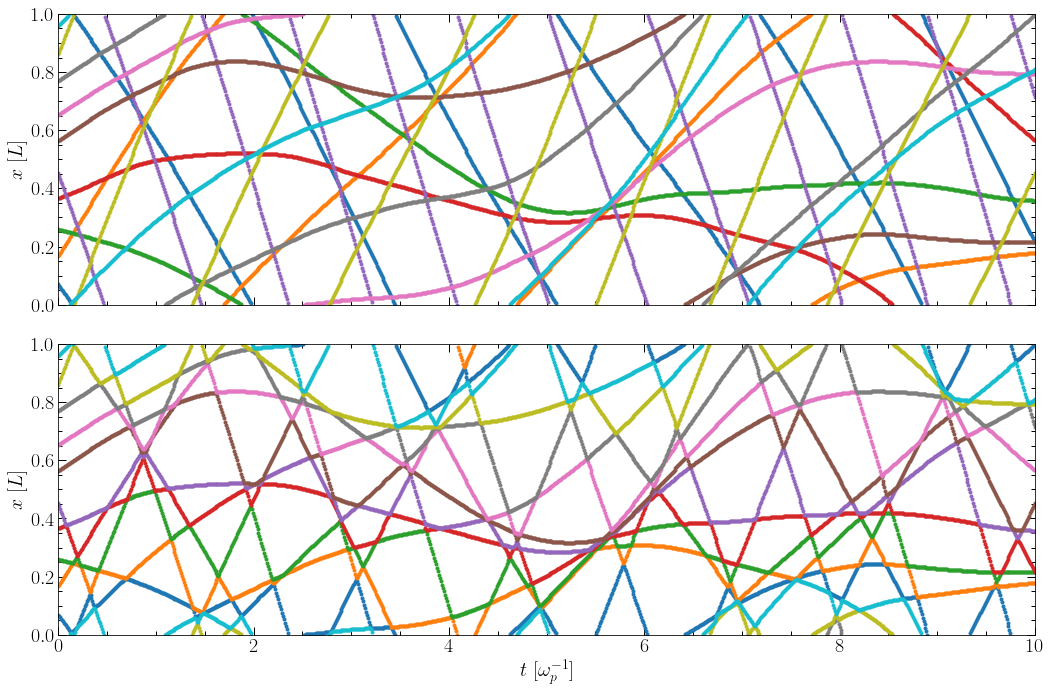

In [13]:
fig, ax = plt.subplots(2,1, figsize=(15,10), sharex=True, sharey=True)

t = np.arange(len(X)) * dt

colors = plt.get_cmap(plt.cm.tab10)(np.arange(X.shape[1]) % 11)

for i in range(X.shape[1]):
    ax[0].plot(t, X[:,i], '.', color=colors[i], rasterized=True)
    ax[1].plot(t, X_sort[:,i], '.', color=colors[i], rasterized=True)

plt.xlabel('$t$ [$\omega_p^{-1}$]')
ax[0].set_ylabel('$x$ [$L$]')
ax[1].set_ylabel('$x$ [$L$]')
plt.xlim([0, t[-1]])
plt.ylim([0, 1])
plt.tight_layout()
plt.savefig('../img/crossings_vs_collisions')
plt.show()

In [14]:
X = np.array([np.load(v) for v in sorted(glob.glob('../../data/dataset/train/10/periodic/x_[0-9]*.npy'))])
V = np.array([np.load(v) for v in sorted(glob.glob('../../data/dataset/train/10/periodic/v_[0-9]*.npy'))])
X_eq = np.array([np.load(v) for v in sorted(glob.glob('../../data/dataset/train/10/periodic/x_eq*.npy'))])
dx_eq = get_dx_eq(n_sheets=X.shape[-1])

X_sort = np.take_along_axis(X, np.argsort(X_eq%1, axis=-1), axis=-1)

In [15]:
def get_target_acceleration(X, dt, L=1):
    dX = np.diff(X, axis=1)
    dX[dX > L/2] -= L
    dX[dX < -L/2] += L
    d2X = np.diff(dX, axis=1)
    return -dX/dt, -d2X/dt**2

DT = [0.01, 0.1]
dt_sim = 0.01

hists = dict()

for dt in DT:
    
    dt_undersample = int(dt/dt_sim)

    dX, d2X = get_target_acceleration(X[:, ::dt_undersample], dt)
    dX_sort, d2X_sort = get_target_acceleration(X_sort[:, ::dt_undersample], dt)

    bins = np.logspace(-1, 4, 100)
    hist_colis = np.histogram(np.abs(d2X_sort.flatten())/dx_eq, bins=bins, density=True)
    hist_cross = np.histogram(np.abs(d2X.flatten())/dx_eq, bins=bins, density=True)
    
    hists[dt] = {'collisions': hist_colis, 'crossings': hist_cross}

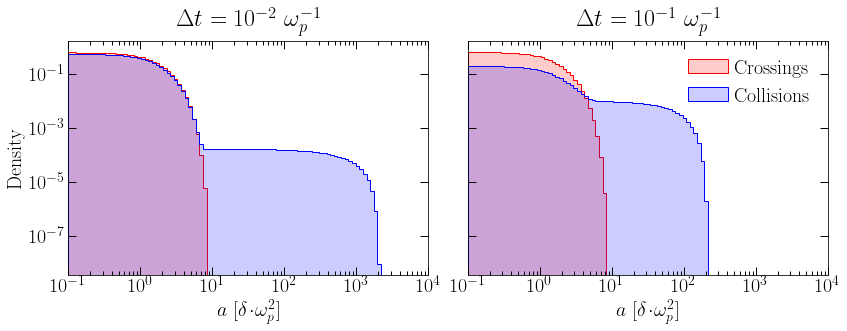

In [16]:
fig, ax = plt.subplots(1,2, figsize=(12,5), sharex=True, sharey=True)

for i, dt in enumerate(DT):
    
    ax[i].stairs(*hists[dt]['crossings'], fill=True, label='Crossings',
                 edgecolor = (1,0,0,1), facecolor=(1,0,0,0.2))
    
    ax[i].stairs(*hists[dt]['collisions'], fill=True, label='Collisions', 
                 edgecolor = (0,0,1,1), facecolor=(0,0,1,0.2))
    
    
    ax[i].set_title(f'$\Delta t = 10^{{{np.log10(dt):.0f}}}~\omega_p^{{-1}}$', pad=15)
    ax[i].set_xlabel('$a$ [$\delta\!\cdot\!\omega_p^2$]')
    
ax[0].set_ylabel('Density')

plt.xlim(bins[0], bins[-1])
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.tight_layout()
plt.savefig(f'../img/crossings_vs_collisions_targets')
plt.show()